In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [17]:
# Load dataset
data_dir = "data_readinglevel"
x_train = pd.read_csv(os.path.join(data_dir, "x_train.csv"))
y_train = pd.read_csv(os.path.join(data_dir, "y_train.csv"))

texts = x_train["text"].tolist()
labels = (y_train["Coarse Label"] == "Key Stage 4-5").astype(int)

vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english",
    token_pattern=r"(?u)\b\w*[^\d\W]\w*\b",
)

X = vectorizer.fit_transform(texts)
vectorizer.get_feature_names_out()

analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze 102.")

['text', 'document', 'analyze']

In [ ]:
# Define hyperparameter grid to search
# C: regularization strength (smaller = more regularization)
# Extended range to show clear underfitting at low C and overfitting at high C
C_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
cv_results = []

print("Running cross-validation across different C values...")
print("-" * 60)

for C in C_values:
    # Create pipeline with current hyperparameters
    pipeline = make_pipeline(
        CountVectorizer(
            lowercase=True,
            stop_words="english",
            token_pattern=r"(?u)\b\w*[^\d\W]\w*\b",
        ),
        LogisticRegression(max_iter=1000, C=C, random_state=42),
    )

    # Perform cross-validation
    scores = cross_val_score(
        pipeline,
        texts,  # type: ignore
        labels,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
    )

    # Store results
    cv_results.append(
        {
            "C": C,
            "mean_auroc": np.mean(scores),
            "std_auroc": np.std(scores),
            "min_auroc": np.min(scores),
            "max_auroc": np.max(scores),
        }
    )

# Convert to DataFrame for easier viewing
results_df = pd.DataFrame(cv_results)

Running cross-validation across different C values...
------------------------------------------------------------

Results Summary:
          C  mean_auroc  std_auroc  min_auroc  max_auroc
0    0.0001    0.724726   0.013991   0.708463   0.740218
1    0.0010    0.740879   0.014538   0.724315   0.759203
2    0.0100    0.779923   0.014267   0.765755   0.801610
3    0.1000    0.818144   0.010529   0.802907   0.831810
4    1.0000    0.824352   0.009246   0.808268   0.834452
5   10.0000    0.821651   0.008707   0.805815   0.830080
6  100.0000    0.822276   0.006629   0.810662   0.829815

Best hyperparameter: C=1.0
Best CV AUROC: 0.8244 ± 0.0092

Results Summary:
          C  mean_auroc  std_auroc  min_auroc  max_auroc
0    0.0001    0.724726   0.013991   0.708463   0.740218
1    0.0010    0.740879   0.014538   0.724315   0.759203
2    0.0100    0.779923   0.014267   0.765755   0.801610
3    0.1000    0.818144   0.010529   0.802907   0.831810
4    1.0000    0.824352   0.009246   0.808268   0

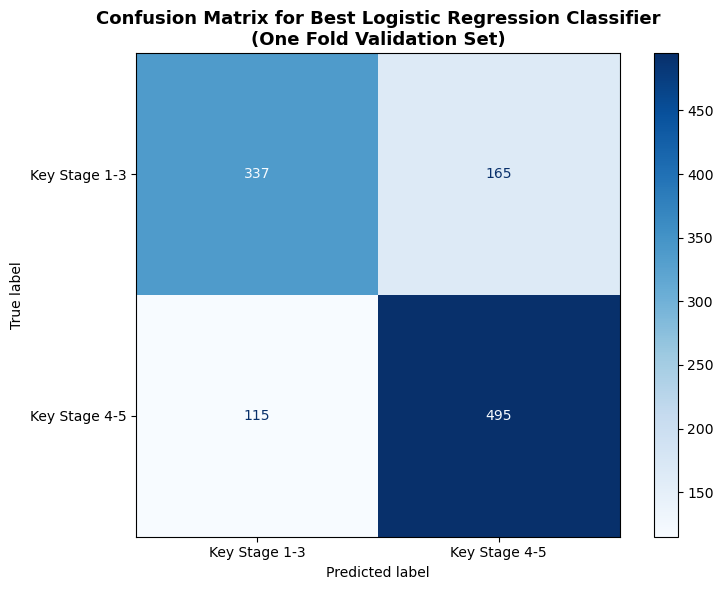

Confusion Matrix Analysis (Best C=1.0):
True Negatives (correctly predicted Key Stage 1-3): 337
False Positives (Key Stage 1-3 predicted as 4-5): 165
False Negatives (Key Stage 4-5 predicted as 1-3): 115
True Positives (correctly predicted Key Stage 4-5): 495

Total validation examples: 1112
Accuracy: 0.7482
False Positive Rate: 0.3287
False Negative Rate: 0.1885


In [ ]:
# Part 1D: Confusion Matrix Analysis for Best Classifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get one fold for analysis
train_idx, val_idx = next(cv.split(texts, labels))

# Prepare data for this fold
train_texts = [texts[i] for i in train_idx]
train_labels = [labels.iloc[i] if hasattr(labels, "iloc") else labels[i] for i in train_idx]
val_texts = [texts[i] for i in val_idx]
val_labels = [labels.iloc[i] if hasattr(labels, "iloc") else labels[i] for i in val_idx]

# Train the best model
pipeline = make_pipeline(
    CountVectorizer(
        lowercase=True,
        stop_words="english",
        token_pattern=r"(?u)\b\w*[^\d\W]\w*\b",
    ),
    LogisticRegression(max_iter=1000, C=best_C, random_state=42),
)
pipeline.fit(train_texts, train_labels)  # type: ignore

# Get predictions on validation set
val_predictions = pipeline.predict(val_texts)  # type: ignore

# Create confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Key Stage 1-3", "Key Stage 4-5"]
)
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("Confusion Matrix for Best Logistic Regression Classifier\n(One Fold Validation Set)", 
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
# Part 1E: BASELINE - Train Final Model and Generate Test Set Predictions

print("=" * 60)
print("BASELINE MODEL: Generating Test Set Predictions")
print("=" * 60)

# Load test data
x_test = pd.read_csv(os.path.join(data_dir, "x_test.csv"))
test_texts = x_test["text"].tolist()

final_pipeline = make_pipeline(
    CountVectorizer(
        lowercase=True,
        stop_words="english",
        token_pattern=r"(?u)\b\w*[^\d\W]\w*\b",
    ),
    LogisticRegression(max_iter=1000, C=best_C, random_state=42),
)

# Fit on entire training set
final_pipeline.fit(texts, labels)  # type: ignore

# Generate probabilistic predictions for test set
test_proba = final_pipeline.predict_proba(test_texts)[:, 1]  # type: ignore

print(f"\nGenerated {len(test_proba)} predictions")
print(f"Probability range: [{test_proba.min():.4f}, {test_proba.max():.4f}]")

# Save predictions to file
output_filename = "yproba1_test_baseline.txt"
np.savetxt(output_filename, test_proba, fmt='%.6f')

In [55]:
# Generate Test Predictions with TF-IDF (bigrams, sublinear_tf, capped vocab)
print("=" * 60)
print("ADVANCED MODEL: TF-IDF (bigrams, sublinear_tf, max_features=30k, min_df=5)")
print("=" * 60)

# Define vectorizer
tfidf_bigrams_vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    token_pattern=r"(?u)\b\w*[^\d\W]\w*\b",
    min_df=5,
    ngram_range=(1,2),
    max_features=30000,
    sublinear_tf=True
)

# Use C=2.0 (from previous best config)
# Use recommended C from hyperparameter search
tfidf_bigrams_C = 0.35
tfidf_bigrams_class_weight = None

# Train on all training data
tfidf_bigrams_pipeline = make_pipeline(
    tfidf_bigrams_vectorizer,
    LogisticRegression(max_iter=1000, C=tfidf_bigrams_C, class_weight=tfidf_bigrams_class_weight, random_state=42)
)
print(f"\nTraining TF-IDF bigrams model on all {len(texts)} training examples...")
tfidf_bigrams_pipeline.fit(texts, labels)  # type: ignore

# Load test data (if not already loaded)
if 'test_texts' not in globals():
    x_test = pd.read_csv(os.path.join(data_dir, "x_test.csv"))
    test_texts = x_test["text"].tolist()

# Check vocabulary size
tfidf_bigrams_vocab_size = len(tfidf_bigrams_pipeline[0].get_feature_names_out())
print(f"Vocabulary size: {tfidf_bigrams_vocab_size} features")

# Generate predictions
tfidf_bigrams_test_proba = tfidf_bigrams_pipeline.predict_proba(test_texts)[:, 1]  # type: ignore
print(f"\nGenerated {len(tfidf_bigrams_test_proba)} predictions")
print(f"Probability range: [{tfidf_bigrams_test_proba.min():.4f}, {tfidf_bigrams_test_proba.max():.4f}]")
print(f"Mean probability: {tfidf_bigrams_test_proba.mean():.4f}")

# Save to file
tfidf_bigrams_output_filename = "yproba1_test.txt"
np.savetxt(tfidf_bigrams_output_filename, tfidf_bigrams_test_proba, fmt='%.6f')
print(f"\n✓ TF-IDF bigrams predictions saved to: {tfidf_bigrams_output_filename}")



ADVANCED MODEL: TF-IDF (bigrams, sublinear_tf, max_features=30k, min_df=5)

Training TF-IDF bigrams model on all 5557 training examples...
Vocabulary size: 7041 features

Generated 1197 predictions
Probability range: [0.1963, 0.8315]
Mean probability: 0.5544

✓ TF-IDF bigrams predictions saved to: yproba1_test.txt


In [ ]:
# Hyperparameter Search: Tune C for TF-IDF (bigrams, sublinear_tf, max_features=30k, min_df=5)
import matplotlib.pyplot as plt

print("=" * 60)
print("Hyperparameter Search: Tuning C for TF-IDF bigrams model")
print("=" * 60)

# Define vectorizer (same as best model)
tfidf_bigrams_vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    token_pattern=r"(?u)\b\w*[^\d\W]\w*\b",
    min_df=5,
    ngram_range=(1,2),
    max_features=30000,
    sublinear_tf=True
)

# Range of C values to try (log scale)
C_values = np.logspace(-3, 3, 12)  # 0.001 to 1000, 12 points
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mean_aurocs = []
std_aurocs = []
for C in C_values:
    pipeline = make_pipeline(
        tfidf_bigrams_vectorizer,
        LogisticRegression(max_iter=1000, C=C, class_weight=None, random_state=42)
    )
    scores = cross_val_score(pipeline, texts, labels, cv=cv, scoring="roc_auc", n_jobs=-1)
    mean_aurocs.append(np.mean(scores))
    std_aurocs.append(np.std(scores))
    print(f"C={C:.4f} | CV AUROC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Plot AUROC vs C
plt.figure(figsize=(10,6))
plt.semilogx(C_values, mean_aurocs, marker='o', label='Mean CV AUROC', color='blue')
plt.fill_between(C_values, np.array(mean_aurocs)-np.array(std_aurocs), np.array(mean_aurocs)+np.array(std_aurocs), color='blue', alpha=0.2, label='±1 Std')
plt.xlabel('Regularization Parameter C (log scale)', fontsize=12)
plt.ylabel('Mean CV AUROC', fontsize=12)
plt.title('TF-IDF (bigrams, sublinear_tf, max_features=30k, min_df=5)\nAUROC vs Regularization Parameter C', fontsize=13, fontweight='bold')
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Print best C
best_idx = np.argmax(mean_aurocs)
best_C = C_values[best_idx]
best_auroc = mean_aurocs[best_idx]
print(f"\nBest C: {best_C:.4f}")
print(f"Best CV AUROC: {best_auroc:.4f}")
print("\nConsider retraining your final model with this C value!")

Training vs Validation AUROC for TF-IDF bigrams model across C


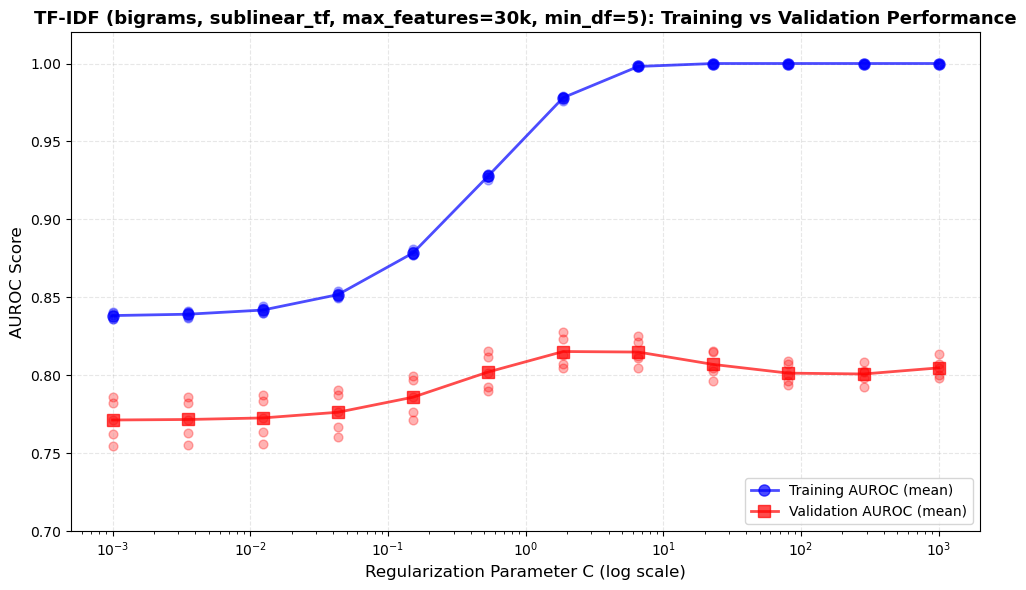

In [48]:
# Visualize Training vs Validation Performance for TF-IDF (bigrams, sublinear_tf, max_features=30k, min_df=5)
import matplotlib.pyplot as plt

print("=" * 60)
print("Training vs Validation AUROC for TF-IDF bigrams model across C")
print("=" * 60)

# Use same C_values as previous hyperparameter search
C_values = np.logspace(-3, 3, 12)  # 0.001 to 1000, 12 points
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_scores_per_C = []
val_scores_per_C = []
for C in C_values:
    train_scores = []
    val_scores = []
    for train_idx, val_idx in cv.split(texts, labels):
        train_texts = [texts[i] for i in train_idx]
        train_labels = [labels.iloc[i] if hasattr(labels, "iloc") else labels[i] for i in train_idx]
        val_texts = [texts[i] for i in val_idx]
        val_labels = [labels.iloc[i] if hasattr(labels, "iloc") else labels[i] for i in val_idx]
        pipeline = make_pipeline(
            TfidfVectorizer(
                lowercase=True,
                stop_words='english',
                token_pattern=r"(?u)\b\w*[^\d\W]\w*\b",
                min_df=5,
                ngram_range=(1,2),
                max_features=30000,
                sublinear_tf=True
            ),
            LogisticRegression(max_iter=1000, C=C, random_state=42)
        )
        pipeline.fit(train_texts, train_labels)  # type: ignore
        train_score = roc_auc_score(train_labels, pipeline.predict_proba(train_texts)[:, 1])  # type: ignore
        val_score = roc_auc_score(val_labels, pipeline.predict_proba(val_texts)[:, 1])  # type: ignore
        train_scores.append(train_score)
        val_scores.append(val_score)
    train_scores_per_C.append(train_scores)
    val_scores_per_C.append(val_scores)

fig, ax = plt.subplots(figsize=(10, 6))
train_means = [np.mean(scores) for scores in train_scores_per_C]
val_means = [np.mean(scores) for scores in val_scores_per_C]
ax.plot(C_values, train_means, "o-", linewidth=2, markersize=8, label="Training AUROC (mean)", color="blue", alpha=0.7)
ax.plot(C_values, val_means, "s-", linewidth=2, markersize=8, label="Validation AUROC (mean)", color="red", alpha=0.7)
for i, C in enumerate(C_values):
    ax.scatter([C] * len(train_scores_per_C[i]), train_scores_per_C[i], alpha=0.3, s=40, color="blue")
    ax.scatter([C] * len(val_scores_per_C[i]), val_scores_per_C[i], alpha=0.3, s=40, color="red")
ax.set_xscale("log")
ax.set_xlabel("Regularization Parameter C (log scale)", fontsize=12)
ax.set_ylabel("AUROC Score", fontsize=12)
ax.set_title("TF-IDF (bigrams, sublinear_tf, max_features=30k, min_df=5): Training vs Validation Performance", fontsize=13, fontweight="bold")
ax.legend(fontsize=10, loc="lower right")
ax.grid(True, alpha=0.3, linestyle="--")
ax.set_ylim([0.70, 1.02])
plt.tight_layout()
plt.show()